Track 1: Reducing Boston’s Carbon Footprint: Participants will use the Boston Energy Reporting and Disclosure Ordinance (BERDO), City of Boston Utility Billing Data, City of Boston Real-Time Energy Metering (coming soon!), and other relevant datasets from Analyze Boston to find new ways to promote energy efficiency and reduce greenhouse gas emissions in Boston. You might (for example) analyze the efficiency of individual buildings relative to their characteristics and usage, develop a new map to highlight Boston's greenest buildings, or create graphs of usage over time to see how Boston's demand for energy is evolving over time.

Carbon neutral: making no net release of carbon dioxide to the atmosphere, especially through offsetting emissions by planting trees.

In order to achive a carbon neutral Boston by 2015 the city needs a good tracking system that integrates with the BERDO data. Tracking how buildings are doing thought the years will allow to get insights about what type of buildings are reducing their carbon emissions and which aren't. 

It will also allow to focus on indivual buldings.

This notebook presents a few examples of what information could be track. At this point in time we only have 2 years data which limits the amount of information we can extract. Once we have more year's data the tracking can be considerable improved.

Time was of the essence here so a few notes have been added to the notebook where things can be improved or need some more research

First, let's import all modules used on this notebook:

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use('fivethirtyeight')

import requests

from mpl_toolkits.basemap import Basemap
import matplotlib.patches as mpatches
plt.rcParams['axes.facecolor'] = 'white'

import warnings
warnings.filterwarnings('ignore')

Here are the versions of Python, modules, server where this notebook was created:

In [5]:
%load_ext watermark
%watermark -d -v -m -p numpy,pandas,matplotlib,scikit-learn

The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark
2017-04-21 

CPython 3.5.1
IPython 4.2.0

numpy 1.12.0
pandas 0.18.1
matplotlib 2.0.0
scikit-learn 0.18.1

compiler   : MSC v.1900 64 bit (AMD64)
system     : Windows
release    : 7
machine    : AMD64
processor  : Intel64 Family 6 Model 58 Stepping 9, GenuineIntel
CPU cores  : 4
interpreter: 64bit


Next, we load the BERDO datasets available (2014, 2015) and we joined them using the features Address and Property name.

In [18]:
berdo2015 = pd.read_csv(".//data/berdo2015.csv", encoding = "ISO-8859-1")
berdo2014 = pd.read_csv(".//data/berdo2014.csv", encoding = "ISO-8859-1")
print("Size of BERDO 2014 data set: %s" %(berdo2014.shape[0]))
print("Size of BERDO 2015 data set: %s" %(berdo2015.shape[0]))
berdo = pd.merge(berdo2015, berdo2014,
                 how='inner',
                 on=['Address','Property Name'],
                 suffixes=('_2015', '_2014'))
#berdo.to_csv(".\\data\\berdo.csv", index=False)

print("Size of joined BERDO data set: %s" %(berdo.shape[0]))

Size of BERDO 2014 data set: 1380
Size of BERDO 2015 data set: 1502
Size of joined BERDO data set: 1085


Not all buildings were in both data sets, at least the property name/address didn't match. As we are tracking progress over time are not iterested in buldings that show up for the first time. 

NOTE: we could check if property name/ address where the best features to joing the data with. Can there be some typos in the address? Do buildings change names? 

Of all the data set we are interested in the following columsn:

* **Property Name**	Property name, as reported by owner
* **Address**	Reported address
* **ZIP**	ZIP
* **Gross Area (sq ft)**	Gross area
* **Site EUI (kBTU/sf)**	Site energy use intensity, or EUI (in kBTU/sq. ft.): This sums up all of the energy used in the building (electricity, gas, steam, etc.) each year, and divides by square footage. There are many drivers of energy use intensity, such as energy-intensive work, and, since EUI is not adjusted for these factors, it is not a definitive indicator of building efficiency. (This metric uses site energy, not source energy.)
Property Uses	List of space uses reported for this property
Year Built	Year built, as reported by the owner
* **GHG Emissions (MTCO2e)**	Greenhouse gas emissions. Portfolio Manager uses averages for the regional electric grid and other fuels to estimate annual greenhouse gas emissions. Buildings and campuses that have central plants or buy bulk power may have different emissions than estimated.
* **GHG Intensity (kgCO2/sf)**	GHG intensity (kgCO2/sf) divides total GHG emissions by square footage.
* **Total Site Energy (kBTU)** 	Total energy used in 2014 (kBTU). This is a gross sum of all annual energy use in the building, not adjusted for size or uses.
* **% Electricity**	Percent of total energy that is electricity
* **% Gas**	Percent of total energy that is gas
* **% Steam**	Percent of total energy that is steam



Next, we proceed to clean the data set, here are the steps taken:

* numerical columns
* 

In [4]:
#berdo = pd.read_csv(".\\data\\berdo.csv")

print(berdo.columns)

cols_num = ['Gross Area (sq ft)', 'Site EUI (kBTU/sf)',
            'GHG Emissions (MTCO2e)', 'GHG Intensity (kgCO2/sf)',
            ' Total Site Energy (kBTU) ','Water Intensity (gal/sf)'
           ]

cols_percent = ["% Gas", "% Steam", "% Electricity"]

def to_number(s):
    """Converts string s to a float.
    Returns -1 if error"""
    try:
        float(s)
        return float(s)
    except ValueError:
        return -1

def fix_numerical(columns):
    """Tranforms numerical columns to number"""
    for c in columns:
        for year in ("_2014","_2015"):
            cyear = c + year
            berdo[cyear] = berdo[cyear].map(lambda x:
                                            str(x).strip().replace(",","")
                                           )
            berdo[cyear] = berdo[cyear].map(to_number)
            cyear = c
            
def fix_percenteage(columns):
    """Tranforms percentage columns to number"""
    for c in columns:
        for year in ("_2014","_2015"):
            cyear = c + year
            berdo[cyear].fillna("0%", inplace=True)
            berdo[cyear] = berdo[cyear].map(lambda x:
                                            float(x.strip().replace("%",""))
                                           )         
            cyear = c

# transform columsn
fix_numerical(cols_num)
fix_percenteage(cols_percent)

berdo["%_total_2015"] = berdo[["% Gas_2015","% Steam_2015","% Electricity_2015"]].sum(axis=1)
berdo["%_total_2014"] = berdo[["% Gas_2014","% Steam_2014","% Electricity_2014"]].sum(axis=1)

# fix year built and crate decade
berdo["Year Built_2015"] = berdo["Year Built_2015"].map(lambda x: x+1000 if ((x < 1013) and (x > 800)) else x)
berdo["Year Built_2015"] = berdo["Year Built_2015"].map(lambda x: -1 if x <=800 else x)
berdo["decade"] = berdo["Year Built_2015"].map(lambda x: int(str(x)[:-1]+"0"))

Index(['Property Name', 'Reported_2015', 'Property Type_2015', 'Address',
       'ZIP_2015', 'Gross Area (sq ft)_2015', 'Site EUI (kBTU/sf)_2015',
       'Energy Star Score_2015', 'Energy Star Certified_2015',
       'Property Uses_2015', 'Year Built_2015', 'GHG Emissions (MTCO2e)_2015',
       'GHG Intensity (kgCO2/sf)_2015', ' Total Site Energy (kBTU) _2015',
       '% Electricity_2015', '% Gas_2015', '% Steam_2015',
       'Water Intensity (gal/sf)_2015', 'Onsite Solar (kWh)_2015',
       'User Submitted Info_2015', 'User Submitted Link_2015',
       'Tax Parcel_2015', 'Years Reported', 'Reported_2014',
       'Property Type_2014', 'ZIP_2014', 'Gross Area (sq ft)_2014',
       'Site EUI (kBTU/sf)_2014', 'Energy Star Score_2014',
       'Energy Star Certified_2014', 'Property Uses_2014', 'Year Built_2014',
       'GHG Emissions (MTCO2e)_2014', 'GHG Intensity (kgCO2/sf)_2014',
       ' Total Site Energy (kBTU) _2014', '% Electricity_2014', '% Gas_2014',
       '% Steam_2014', 'Water I

In [5]:
berdo = berdo[["Property Name","Address","ZIP_2015","Year Built_2015","decade",
               "Property Type_2015","Property Type_2014",
               "Gross Area (sq ft)_2015","Gross Area (sq ft)_2014",
               "Site EUI (kBTU/sf)_2015","Site EUI (kBTU/sf)_2014",
               " Total Site Energy (kBTU) _2015"," Total Site Energy (kBTU) _2014",
               "GHG Emissions (MTCO2e)_2015","GHG Emissions (MTCO2e)_2014",
               "GHG Intensity (kgCO2/sf)_2015","GHG Intensity (kgCO2/sf)_2014",
               "% Electricity_2015", "% Gas_2015", "% Steam_2015","%_total_2015",
               "% Electricity_2014", "% Gas_2014", "% Steam_2014","%_total_2014"
              ]]

### remove data that doesn't seem right. A deeper investigation should be done here
#print(berdo.isnull().sum())
print(berdo.shape)

print("---------")

# set values -1 to NaN
berdo.replace(-1,np.NaN,inplace=True)
# remove if total energy < 90. Check these deeper
berdo = berdo[(berdo["%_total_2015"] > 90) & (berdo["%_total_2014"] > 90)]
# drop all missing values
berdo.dropna(axis=0, how='any', inplace=True)
print(berdo.shape)

(1086, 25)
---------
(923, 25)


In [6]:
berdo_diff = pd.DataFrame()
berdo_diff[["property_name", "address","zip","year_built","decade"]] = berdo[["Property Name",
                                                                              "Address","ZIP_2015",
                                                                              "Year Built_2015",
                                                                              "decade"]]
berdo_diff[["property_type_2015","property_type_2014"]] = berdo[["Property Type_2015",
                                                                 "Property Type_2014"]]
berdo_diff["gloss_area_sqft"] = berdo["Gross Area (sq ft)_2015"]
berdo_diff["gloss_area_sqft_diff"] = berdo["Gross Area (sq ft)_2015"] - berdo["Gross Area (sq ft)_2014"]
berdo_diff["energy_kbtu/sf_diff"] = berdo["Site EUI (kBTU/sf)_2015"] - berdo["Site EUI (kBTU/sf)_2014"]
berdo_diff["energy_total_kbtu_diff"] = berdo[" Total Site Energy (kBTU) _2015"] - berdo[" Total Site Energy (kBTU) _2014"]
berdo_diff["ghg_emissions_mtco2e_diff"] = berdo["GHG Emissions (MTCO2e)_2015"] - berdo["GHG Emissions (MTCO2e)_2014"]
berdo_diff["ghg_intensity_kgco2/sf_diff"] = berdo["GHG Intensity (kgCO2/sf)_2015"] - berdo["GHG Intensity (kgCO2/sf)_2014"]
berdo_diff[["%_electricity_2015","%_gas_2015","%_steam_2015"]] = berdo[["% Electricity_2015",
                                                                        "% Gas_2015",
                                                                        "% Steam_2015"]]
berdo_diff[["%_electricity_2014","%_gas_2014","%_steam_2014"]] = berdo[["% Electricity_2014",
                                                                        "% Gas_2014",
                                                                        "% Steam_2014"]]

# quantiles
berdo_diff['energy_kbtu/sf_diff_Q'] = pd.qcut(berdo_diff['energy_kbtu/sf_diff'],
                                              4,
                                              labels=False)
berdo_diff['ghg_intensity_kgco2/sf_diff_Q'] = pd.qcut(berdo_diff['ghg_intensity_kgco2/sf_diff'],
                                                      4,
                                                      labels=False)

In [7]:
import requests

def get_long_lat(address):
  
    fix_add = address.replace(" ","+")
    url = 'https://maps.googleapis.com/maps/api/geocode/json?address=' + fix_add + ',+Boston,+Massachusetts,+USA'
    try:        
        response = requests.get(url)
        resp_json_payload = response.json()
        #print(resp_json_payload)
        info = (resp_json_payload['results'][0]['geometry']['location'])
    except:
        return "0 0" 
            
    return (str(info['lat'])+" "+str(info['lng']))

berdo_diff["lat_long"] =  berdo_diff.address.map(get_long_lat)

In [8]:
#berdo_diff = pd.read_csv("./data/berdo_diff.csv")

def redo_long_lat(row):
    
    if row["lat_long"] == "0 0":
        address = row["address"]  
        fix_add = address.replace(" ","+")
        url = 'https://maps.googleapis.com/maps/api/geocode/json?address=' + fix_add + ',+Boston,+Massachusetts,+USA'
        try:        
            response = requests.get(url)
            resp_json_payload = response.json()
            #print(resp_json_payload)
            info = (resp_json_payload['results'][0]['geometry']['location'])
            return str(info['lat'])+" "+str(info['lng'])
        except:
            return "0 0" 
    else:
        return row["lat_long"]
        

berdo_diff["lat_long"] =  berdo_diff.apply(redo_long_lat, axis=1)

In [9]:
print(berdo_diff.lat_long.isnull().sum())
print(berdo_diff.lat_long.value_counts()[:5])

0
42.4664625 -71.3977929           16
0 0                              12
42.3550045 -71.0567466            7
42.2728572 -71.0976218            4
42.3393661 -71.09993589999999     3
Name: lat_long, dtype: int64


In [10]:
berdo_diff["lat"] = berdo_diff.lat_long.map(lambda x: float(x.split()[0]))
berdo_diff["long"] = berdo_diff.lat_long.map(lambda x: float(x.split()[1]))

In [11]:
berdo_diff.head(2)

,property_name,address,zip,year_built,decade,property_type_2015,property_type_2014,gloss_area_sqft,gloss_area_sqft_diff,energy_kbtu/sf_diff,...,%_gas_2015,%_steam_2015,%_electricity_2014,%_gas_2014,%_steam_2014,energy_kbtu/sf_diff_Q,ghg_intensity_kgco2/sf_diff_Q,lat_long,lat,long
0,#2679 south bay/boston,5 alllstate road,02125,1998,1990,Retail Store,Retail Store,132000.0,0.0,6.9,...,44.0,0.0,63.0,37.0,0.0,3,3,42.327989 -71.063485,42.327989,-71.063485
1,0004 roslindale,950 american legion hgwy,02131,2001,2000,Supermarket/Grocery Store,Supermarket/Grocery Store,38694.0,0.0,-2.8,...,39.0,0.0,64.0,36.0,0.0,1,0,42.27578219999999 -71.1142732,42.275782,-71.114273


In [12]:
#berdo_diff.drop(["lat_long"],inplace=True)
berdo_diff.to_csv("./data/berdo_diff.csv", index=False)

1) Map with highest to lowest diff

2) avg/median diff by property type

3) avg/median diff by property zip code

4) avg/median diff by property decade built


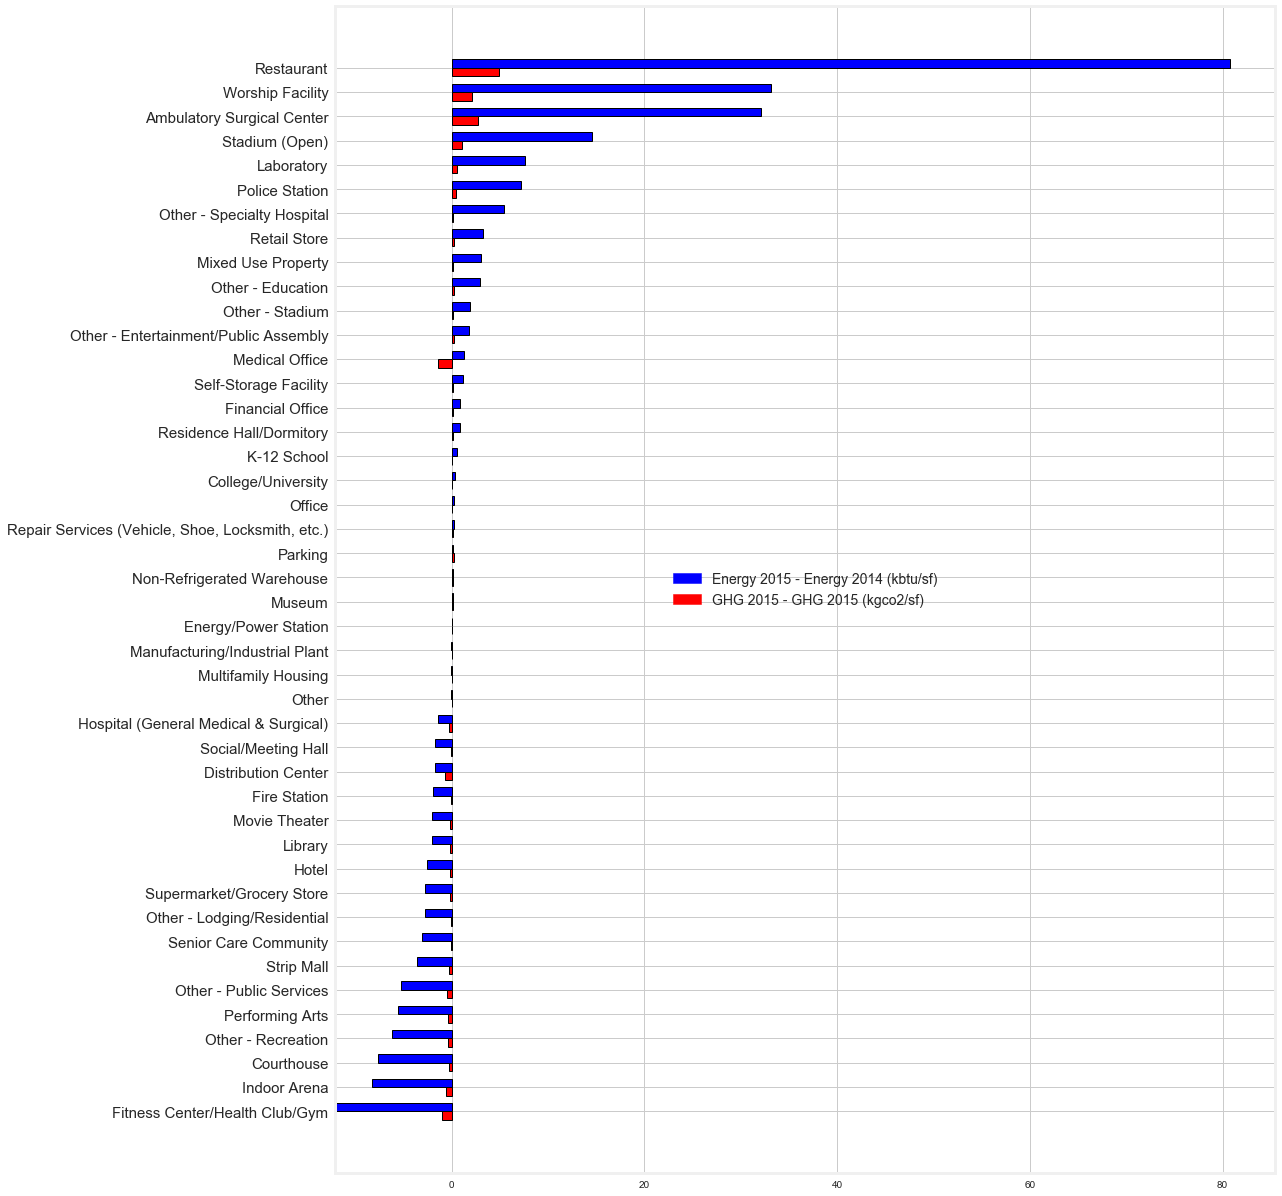

In [15]:
# data to plot
a = berdo_diff.groupby(["property_type_2015"])['energy_kbtu/sf_diff'].median()
a = a[a <1000].sort_values()
b = berdo_diff.groupby(["property_type_2015"])['ghg_intensity_kgco2/sf_diff'].median()
b = b[b <500].sort_values()
c = pd.concat([a, b], axis=1).sort_values("energy_kbtu/sf_diff")

# plot 
plt.figure(figsize=(15, 20),
           facecolor='white')

ax=plt.subplot2grid((1,1), (0,0))

width = 0.35
ind = range(len(c.index))
aa=  [x+width for x in range(len(c.index))]
bb = [x for x in range(len(c.index))]

ax.barh(bottom=aa,
        width=c["energy_kbtu/sf_diff"].values,
        color="b",
        align="center",
        edgecolor = "black",
        linewidth = 1,
        height=width)

ax.barh(bottom=bb,
        width=c["ghg_intensity_kgco2/sf_diff"].values,
        color="r",
        align="center",
        edgecolor = "black",
        linewidth = 1,
        height=width)

ax.set_yticks(range(len(c.index)), [x for x in a.index])

ax.set_yticks([x+width/2 for x in ind])
ax.set_yticklabels([x for x in c.index], size=15)

# legend
import matplotlib.patches as mpatches
blue_patch = mpatches.Patch(color='blue',
                            label='Energy 2015 - Energy 2014 (kbtu/sf)')
red_patch = mpatches.Patch(color='red',
                           label='GHG 2015 - GHG 2015 (kgco2/sf)')

l = plt.legend(handles=[blue_patch,red_patch],
               loc='center',
               prop={'size':14})

plt.show()

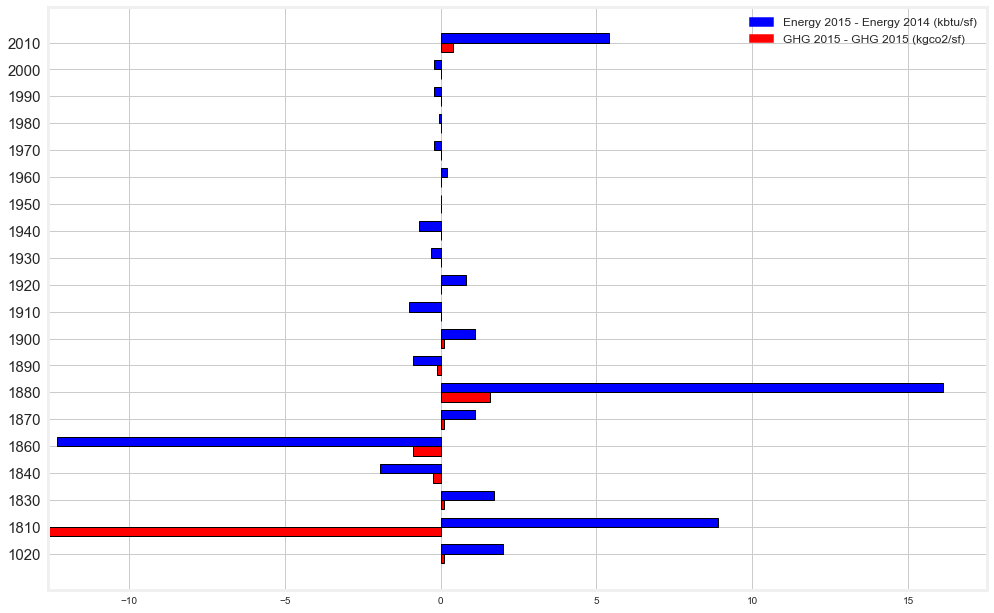

In [16]:
# data to plot
a = berdo_diff.groupby(["decade"])['energy_kbtu/sf_diff'].median()
a = a[a <1000].sort_values()
b = berdo_diff.groupby(["decade"])['ghg_intensity_kgco2/sf_diff'].median()
b = b[b <500].sort_values()
c = pd.concat([a, b], axis=1).sort_index()

# plot
plt.figure(figsize=(15, 10),
           facecolor='white')
ax=plt.subplot2grid((1,1), (0,0))

width = 0.35
ind = range(len(c.index))
aa=  [x+width for x in range(len(c.index))]
bb = [x for x in range(len(c.index))]
ax.barh(bottom=aa,
        width=c["energy_kbtu/sf_diff"].values,
        color="b", 
        align="center",
        edgecolor = "black",
        linewidth = 1,
        height=width)

ax.barh(bottom=bb, 
        width=c["ghg_intensity_kgco2/sf_diff"].values,
        color="r",
        align="center",
        edgecolor = "black",
        linewidth = 1,
        height=width)

ax.set_yticks(range(len(c.index)), [x for x in a.index])

ax.set_yticks([x+width/2 for x in ind])
ax.set_yticklabels([x for x in c.index], size=15)

# legend
import matplotlib.patches as mpatches
blue_patch = mpatches.Patch(color='blue',
                            label='Energy 2015 - Energy 2014 (kbtu/sf)')
red_patch = mpatches.Patch(color='red',
                           label='GHG 2015 - GHG 2015 (kgco2/sf)')

l = plt.legend(handles=[blue_patch,red_patch],
               loc='upper right',
               prop={'size':12})

plt.show()

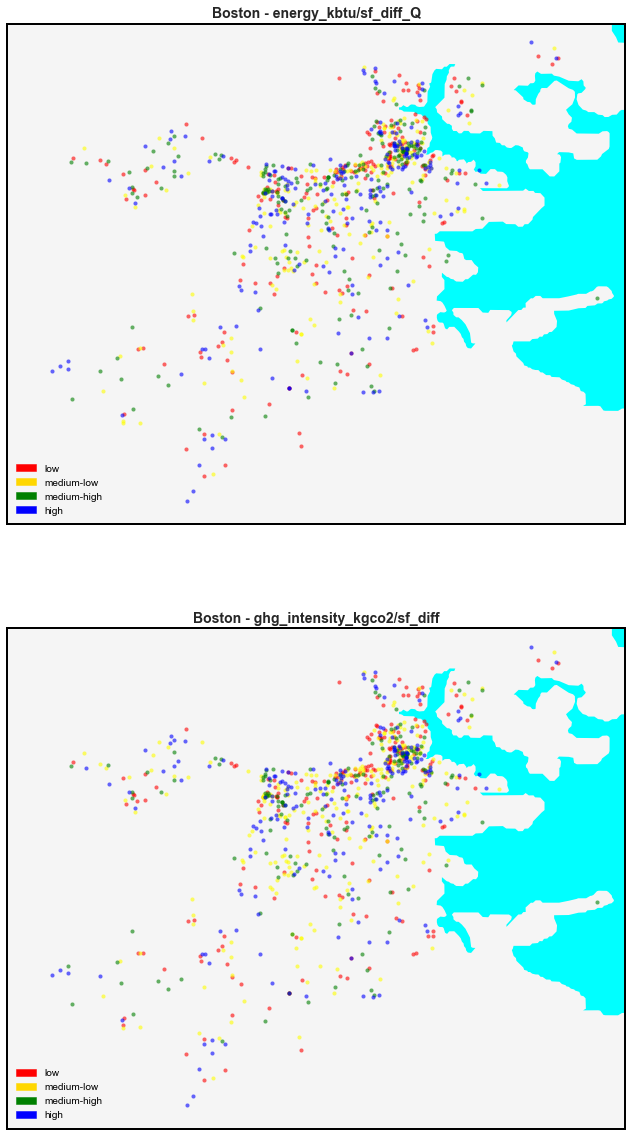

In [17]:
low = berdo_diff[berdo_diff['energy_kbtu/sf_diff_Q'] == 0]
medium_low = berdo_diff[berdo_diff['energy_kbtu/sf_diff_Q'] == 1]
medium_high = berdo_diff[berdo_diff['energy_kbtu/sf_diff_Q'] == 2]
high = berdo_diff[berdo_diff['energy_kbtu/sf_diff_Q'] == 3]

west, south, east, north = -71.1958, 42.2254, -70.9804, 42.40

fig = plt.figure(figsize=(9,17),
                 facecolor='white')

fig.add_subplot(211)
m = Basemap(llcrnrlat=south,
            urcrnrlat=north, 
            llcrnrlon=west,
            urcrnrlon=east,
            lat_ts=south,
            resolution='f')

m.fillcontinents(color='whitesmoke',
                 lake_color='aqua')
m.drawmapboundary(color='black',
                  linewidth=2,
                  fill_color='aqua')
m.drawrivers(color="aqua")


m.plot(low["long"].values, low["lat"].values,
       'bo', 
       markersize=4,
       color='red',
       alpha=0.6,
       markeredgecolor='red',
       markeredgewidth=0.05) 


m.plot(medium_low["long"].values,
       medium_low["lat"].values,
       'bo', 
       markersize=4,
       color='yellow',
       alpha=0.6,
       markeredgecolor='yellow',
       markeredgewidth=0.05) 


m.plot(medium_high["long"].values,
       medium_high["lat"].values,
       'bo', 
       markersize=4,
       color='green',
       alpha=0.6,
       markeredgecolor='green',
       markeredgewidth=0.05) 


m.plot(high["long"].values,
       high["lat"].values,
       'bo', 
       markersize=4,
       color='blue',
       alpha=0.6,
       markeredgecolor='blue',
       markeredgewidth=0.05) 


plt.title("Boston - energy_kbtu/sf_diff_Q",fontweight = 'bold', size=14)

#legend
red_patch = mpatches.Patch(color='red',
                           label='low')
yellow_patch = mpatches.Patch(color='gold',
                              label='medium-low')
green_patch = mpatches.Patch(color='green',
                             label='medium-high')
blue_patch = mpatches.Patch(color='blue',
                            label='high')
l = plt.legend(handles=[red_patch,
                        yellow_patch,
                        green_patch,
                        blue_patch])

for text in l.get_texts():
    text.set_color("black")

###########################

low = berdo_diff[berdo_diff['ghg_intensity_kgco2/sf_diff_Q'] == 0]
medium_low = berdo_diff[berdo_diff['ghg_intensity_kgco2/sf_diff_Q'] == 1]
medium_high = berdo_diff[berdo_diff['ghg_intensity_kgco2/sf_diff_Q'] == 2]
high = berdo_diff[berdo_diff['ghg_intensity_kgco2/sf_diff_Q'] == 3]

fig.add_subplot(212)
m = Basemap(llcrnrlat=south,
            urcrnrlat=north,
            llcrnrlon=west,
            urcrnrlon=east,
            lat_ts=south,
            resolution='f')

m.fillcontinents(color='whitesmoke',
                 lake_color='aqua')
m.drawmapboundary(color='black',
                  linewidth=2,
                  fill_color='aqua')
m.drawrivers(color="white")


m.plot(low["long"].values, low["lat"].values,
       'bo', 
       markersize=4,
       color='red',
       alpha=0.6,
       markeredgecolor='red',
       markeredgewidth=0.05) 


m.plot(medium_low["long"].values, medium_low["lat"].values,
       'bo', 
       markersize=4,
       color='yellow',
       alpha=0.6,
       markeredgecolor='yellow',
       markeredgewidth=0.06) 


m.plot(medium_high["long"].values, medium_high["lat"].values,
       'bo', 
       markersize=4,
       color='green',
       alpha=0.6,
       markeredgecolor='green',
       markeredgewidth=0.05) 


m.plot(high["long"].values, high["lat"].values,
       'bo', 
       markersize=4,
       color='blue',
       alpha=0.6,
       markeredgecolor='blue',
       markeredgewidth=0.05) 


plt.title("Boston - ghg_intensity_kgco2/sf_diff",fontweight = 'bold', size=14)

#legend
red_patch = mpatches.Patch(color='red',
                           label='low')
yellow_patch = mpatches.Patch(color='gold',
                              label='medium-low')
green_patch = mpatches.Patch(color='green',
                             label='medium-high')
blue_patch = mpatches.Patch(color='blue',
                            label='high')
l = plt.legend(handles=[red_patch,
                        yellow_patch,
                        green_patch,
                        blue_patch])
for text in l.get_texts():
    text.set_color("black")

    
plt.tight_layout()    
plt.show()

In [156]:
berdo_diff['ghg_intensity_kgco2/sf_diff'].value_counts().sort_index().iloc[:10]

-4851.7    1
-3661.2    1
-3591.9    1
-1343.7    1
-180.7     1
-120.1     1
-48.2      1
-28.3      1
-24.8      1
-20.6      1
Name: ghg_intensity_kgco2/sf_diff, dtype: int64

In [157]:
berdo_diff['ghg_intensity_kgco2/sf_diff'].value_counts().sort_index().iloc[-10:]

10.4      1
11.2      1
11.8      1
14.2      1
16.1      1
19.3      1
26.5      1
53.9      1
541.7     1
1691.5    1
Name: ghg_intensity_kgco2/sf_diff, dtype: int64

In [47]:
bad_energy_share

,%_electricity_2014,%_gas_2014,%_steam_2014,%_electricity_2015,%_gas_2015,%_steam_2015,address
106,89.0,0.0,11.0,1.0,0.0,99.0,230 congress street
123,52.0,48.0,0.0,6.0,94.0,0.0,264-270 bay state road
152,37.0,63.0,0.0,0.0,100.0,0.0,330 beacon street
278,48.0,52.0,0.0,19.0,81.0,0.0,983-985 commonwealth avenue
379,100.0,0.0,0.0,100.0,0.0,0.0,225 southhampton st
704,81.0,19.0,0.0,48.0,52.0,0.0,250 northern ave
939,1.0,99.0,0.0,2.0,98.0,0.0,120 h street


In [45]:
bad_energy_share = berdo_diff[["%_electricity_2014","%_gas_2014",
                               "%_steam_2014","%_electricity_2015",
                               "%_gas_2015","%_steam_2015","address"]][berdo_diff['energy_kbtu/sf_diff'] > 200]

In [148]:
 berdo_diff[["%_electricity_2014","%_gas_2014",
                               "%_steam_2014","%_electricity_2015",
                               "%_gas_2015","%_steam_2015","address"]][berdo_diff['energy_kbtu/sf_diff'] > 200]

,%_electricity_2014,%_gas_2014,%_steam_2014,%_electricity_2015,%_gas_2015,%_steam_2015,address
106,89.0,0.0,11.0,1.0,0.0,99.0,230 congress street
123,52.0,48.0,0.0,6.0,94.0,0.0,264-270 bay state road
152,37.0,63.0,0.0,0.0,100.0,0.0,330 beacon street
278,48.0,52.0,0.0,19.0,81.0,0.0,983-985 commonwealth avenue
379,100.0,0.0,0.0,100.0,0.0,0.0,225 southhampton st
704,81.0,19.0,0.0,48.0,52.0,0.0,250 northern ave
939,1.0,99.0,0.0,2.0,98.0,0.0,120 h street


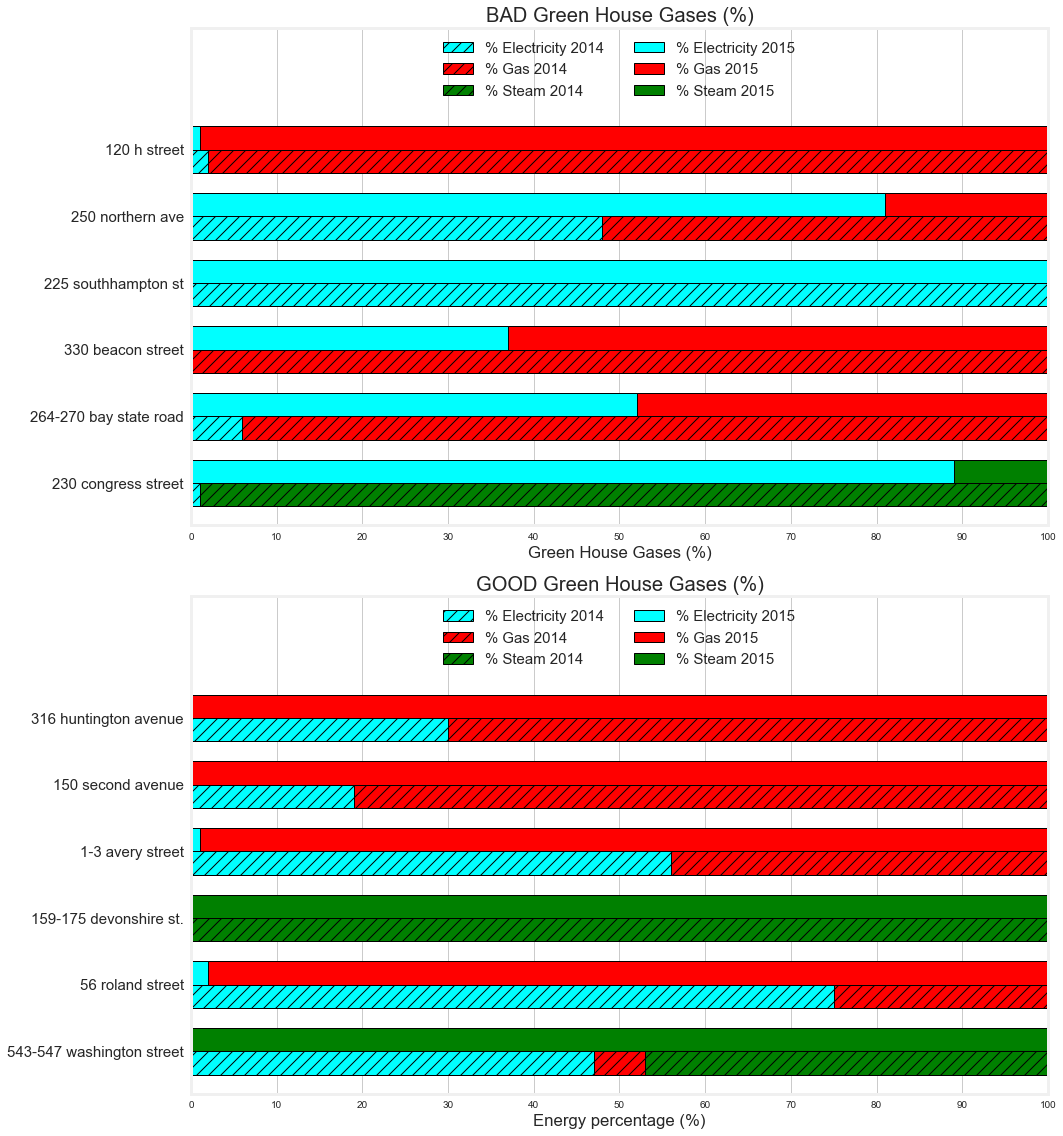

In [158]:
############################ BEST


# data to plot
bad_energy_share = berdo_diff[["%_electricity_2014","%_gas_2014",
                               "%_steam_2014","%_electricity_2015",
                               "%_gas_2015","%_steam_2015","address"]][berdo_diff['ghg_intensity_kgco2/sf_diff'] > 15]

#stacked bars
aa=  [x+width for x in range(len(bad_energy_share.index))]
bb = [x for x in range(len(bad_energy_share.index))]



ind = np.arange(len(bad_energy_share))    # the x locations for the groups
width = 0.35       # the width of the bars: can also be len(x) sequence


fig = plt.figure(figsize=(15,16),
                 facecolor='white')

ax=plt.subplot2grid((2,1), (0,0))

w1 = ax.barh(aa,
             bad_energy_share["%_electricity_2014"],
             width,
             align="center",
             color='aqua',
             edgecolor = "black",
             linewidth = 1)
             #bottom=[x+width for x in ind])#, yerr=menStd)
w2 = ax.barh(aa,
             bad_energy_share["%_gas_2014"], 
             width,
             align="center",
             color="red",
             edgecolor = "black",
             linewidth = 1,
             left= bad_energy_share["%_electricity_2014"])#, yerr=womenStd)
w3 = ax.barh(aa,
             bad_energy_share["%_steam_2014"],
             width,
             align="center",
             color='green',
             edgecolor = "black",
             linewidth = 1,
             left= bad_energy_share["%_electricity_2014"]+bad_energy_share["%_gas_2014"])


v1= ax.barh(bb,
        bad_energy_share["%_electricity_2015"],
        width,
        align="center",
        color='aqua',
        edgecolor = "black",
        hatch="//",
        linewidth = 1)
             #bottom=[x+width for x in ind])#, yerr=menStd)
v2 = ax.barh(bb,
        bad_energy_share["%_gas_2015"], 
        width,
        align="center",
        color="red",
        edgecolor = "black",
        linewidth = 1,
        hatch="//",
        left= bad_energy_share["%_electricity_2015"])#, yerr=womenStd)
v3 = ax.barh(bb,
        bad_energy_share["%_steam_2015"],
        width,
        align="center",
        color='green',
        edgecolor = "black",
        linewidth = 1,
        hatch="//",
        left= bad_energy_share["%_electricity_2015"]+bad_energy_share["%_gas_2015"],)

plt.yticks(ind+2)
ax.set_yticks([x+width/2 for x in ind])
ax.set_yticklabels([x for x in bad_energy_share.address], size=15)


plt.xlabel('Green House Gases (%)')
plt.title('BAD Green House Gases (%)')

plt.xticks(np.arange(0,101,10))
plt.legend((v1[0], v2[0],v3[0],w1[0], w2[0],w3[0]), ('% Electricity 2014',
                                                     '% Gas 2014',
                                                     '% Steam 2014',
                                                     '% Electricity 2015',
                                                     '% Gas 2015',
                                                     '% Steam 2015'),
            prop={'size':15},
            loc='upper center',
            ncol=2)

############################ BEST

# data to plot
bad_energy_share = berdo_diff[["%_electricity_2014","%_gas_2014",
                               "%_steam_2014","%_electricity_2015",
                               "%_gas_2015","%_steam_2015","address"]][berdo_diff['ghg_intensity_kgco2/sf_diff'] < -100]

#stacked bars
aa=  [x+width for x in range(len(bad_energy_share.index))]
bb = [x for x in range(len(bad_energy_share.index))]



ind = np.arange(len(bad_energy_share))    # the x locations for the groups
width = 0.35       # the width of the bars: can also be len(x) sequence


ax=plt.subplot2grid((2,1), (1,0))

w1 = ax.barh(aa,
             bad_energy_share["%_electricity_2014"],
             width,
             align="center",
             color='aqua',
             edgecolor = "black",
             linewidth = 1)
             #bottom=[x+width for x in ind])#, yerr=menStd)
w2 = ax.barh(aa,
             bad_energy_share["%_gas_2014"], 
             width,
             align="center",
             color="red",
             edgecolor = "black",
             linewidth = 1,
             left= bad_energy_share["%_electricity_2014"])#, yerr=womenStd)
w3 = ax.barh(aa,
             bad_energy_share["%_steam_2014"],
             width,
             align="center",
             color='green',
             edgecolor = "black",
             linewidth = 1,
             left= bad_energy_share["%_electricity_2014"]+bad_energy_share["%_gas_2014"])


v1= ax.barh(bb,
        bad_energy_share["%_electricity_2015"],
        width,
        align="center",
        color='aqua',
        edgecolor = "black",
        hatch="//",
        linewidth = 1)
             #bottom=[x+width for x in ind])#, yerr=menStd)
v2 = ax.barh(bb,
        bad_energy_share["%_gas_2015"], 
        width,
        align="center",
        color="red",
        edgecolor = "black",
        linewidth = 1,
        hatch="//",
        left= bad_energy_share["%_electricity_2015"])#, yerr=womenStd)
v3 = ax.barh(bb,
        bad_energy_share["%_steam_2015"],
        width,
        align="center",
        color='green',
        edgecolor = "black",
        linewidth = 1,
        hatch="//",
        left= bad_energy_share["%_electricity_2015"]+bad_energy_share["%_gas_2015"],)

plt.yticks(ind+2)
ax.set_yticks([x+width/2 for x in ind])
ax.set_yticklabels([x for x in bad_energy_share.address], size=15)


plt.xlabel('Energy percentage (%)')
plt.title('GOOD Green House Gases (%)')

plt.xticks(np.arange(0,101,10))
plt.legend((v1[0], v2[0],v3[0],w1[0], w2[0],w3[0]), ('% Electricity 2014',
                                                     '% Gas 2014',
                                                     '% Steam 2014',
                                                     '% Electricity 2015',
                                                     '% Gas 2015',
                                                     '% Steam 2015'),
            prop={'size':15},
            loc='upper center',
            ncol=2)



plt.tight_layout()
plt.show()

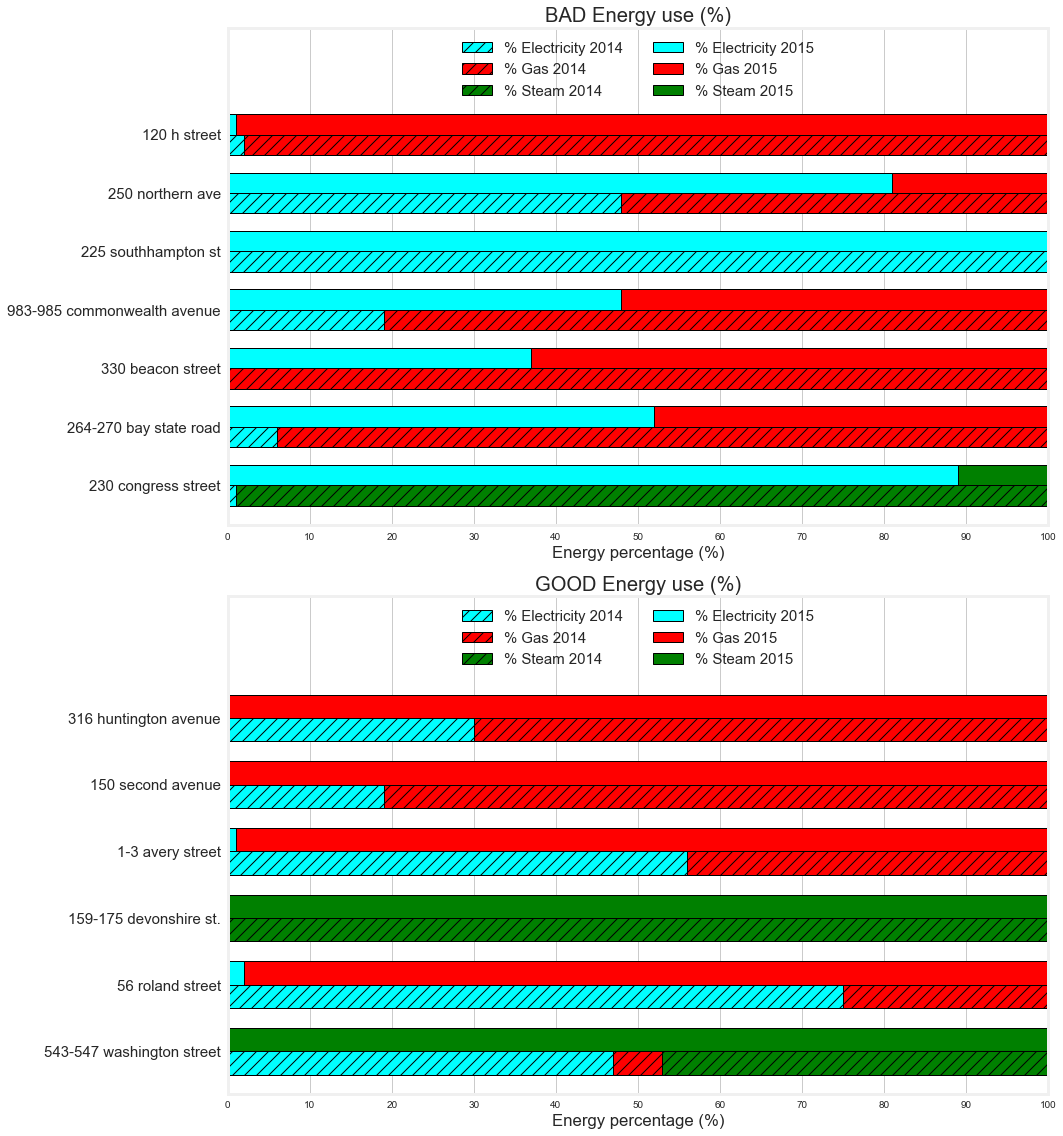

In [152]:
############################ BEST


# data to plot
bad_energy_share = berdo_diff[["%_electricity_2014","%_gas_2014",
                               "%_steam_2014","%_electricity_2015",
                               "%_gas_2015","%_steam_2015","address"]][berdo_diff['energy_kbtu/sf_diff'] > 200]

#stacked bars
aa=  [x+width for x in range(len(bad_energy_share.index))]
bb = [x for x in range(len(bad_energy_share.index))]



ind = np.arange(len(bad_energy_share))    # the x locations for the groups
width = 0.35       # the width of the bars: can also be len(x) sequence


fig = plt.figure(figsize=(15,16),
                 facecolor='white')

ax=plt.subplot2grid((2,1), (0,0))

w1 = ax.barh(aa,
             bad_energy_share["%_electricity_2014"],
             width,
             align="center",
             color='aqua',
             edgecolor = "black",
             linewidth = 1)
             #bottom=[x+width for x in ind])#, yerr=menStd)
w2 = ax.barh(aa,
             bad_energy_share["%_gas_2014"], 
             width,
             align="center",
             color="red",
             edgecolor = "black",
             linewidth = 1,
             left= bad_energy_share["%_electricity_2014"])#, yerr=womenStd)
w3 = ax.barh(aa,
             bad_energy_share["%_steam_2014"],
             width,
             align="center",
             color='green',
             edgecolor = "black",
             linewidth = 1,
             left= bad_energy_share["%_electricity_2014"]+bad_energy_share["%_gas_2014"])


v1= ax.barh(bb,
        bad_energy_share["%_electricity_2015"],
        width,
        align="center",
        color='aqua',
        edgecolor = "black",
        hatch="//",
        linewidth = 1)
             #bottom=[x+width for x in ind])#, yerr=menStd)
v2 = ax.barh(bb,
        bad_energy_share["%_gas_2015"], 
        width,
        align="center",
        color="red",
        edgecolor = "black",
        linewidth = 1,
        hatch="//",
        left= bad_energy_share["%_electricity_2015"])#, yerr=womenStd)
v3 = ax.barh(bb,
        bad_energy_share["%_steam_2015"],
        width,
        align="center",
        color='green',
        edgecolor = "black",
        linewidth = 1,
        hatch="//",
        left= bad_energy_share["%_electricity_2015"]+bad_energy_share["%_gas_2015"],)

plt.yticks(ind+2)
ax.set_yticks([x+width/2 for x in ind])
ax.set_yticklabels([x for x in bad_energy_share.address], size=15)


plt.xlabel('Energy percentage (%)')
plt.title('GOOD Energy use (%)')

plt.xticks(np.arange(0,101,10))
plt.legend((v1[0], v2[0],v3[0],w1[0], w2[0],w3[0]), ('% Electricity 2014',
                                                     '% Gas 2014',
                                                     '% Steam 2014',
                                                     '% Electricity 2015',
                                                     '% Gas 2015',
                                                     '% Steam 2015'),
            prop={'size':15},
            loc='upper center',
            ncol=2)

############################ BEST

# data to plot
bad_energy_share = berdo_diff[["%_electricity_2014","%_gas_2014",
                               "%_steam_2014","%_electricity_2015",
                               "%_gas_2015","%_steam_2015","address"]][berdo_diff['energy_kbtu/sf_diff'] < -1000]

#stacked bars
aa=  [x+width for x in range(len(bad_energy_share.index))]
bb = [x for x in range(len(bad_energy_share.index))]



ind = np.arange(len(bad_energy_share))    # the x locations for the groups
width = 0.35       # the width of the bars: can also be len(x) sequence


ax=plt.subplot2grid((2,1), (1,0))

w1 = ax.barh(aa,
             bad_energy_share["%_electricity_2014"],
             width,
             align="center",
             color='aqua',
             edgecolor = "black",
             linewidth = 1)
             #bottom=[x+width for x in ind])#, yerr=menStd)
w2 = ax.barh(aa,
             bad_energy_share["%_gas_2014"], 
             width,
             align="center",
             color="red",
             edgecolor = "black",
             linewidth = 1,
             left= bad_energy_share["%_electricity_2014"])#, yerr=womenStd)
w3 = ax.barh(aa,
             bad_energy_share["%_steam_2014"],
             width,
             align="center",
             color='green',
             edgecolor = "black",
             linewidth = 1,
             left= bad_energy_share["%_electricity_2014"]+bad_energy_share["%_gas_2014"])


v1= ax.barh(bb,
        bad_energy_share["%_electricity_2015"],
        width,
        align="center",
        color='aqua',
        edgecolor = "black",
        hatch="//",
        linewidth = 1)
             #bottom=[x+width for x in ind])#, yerr=menStd)
v2 = ax.barh(bb,
        bad_energy_share["%_gas_2015"], 
        width,
        align="center",
        color="red",
        edgecolor = "black",
        linewidth = 1,
        hatch="//",
        left= bad_energy_share["%_electricity_2015"])#, yerr=womenStd)
v3 = ax.barh(bb,
        bad_energy_share["%_steam_2015"],
        width,
        align="center",
        color='green',
        edgecolor = "black",
        linewidth = 1,
        hatch="//",
        left= bad_energy_share["%_electricity_2015"]+bad_energy_share["%_gas_2015"],)

plt.yticks(ind+2)
ax.set_yticks([x+width/2 for x in ind])
ax.set_yticklabels([x for x in bad_energy_share.address], size=15)


plt.xlabel('Energy percentage (%)')
plt.title('BAD Energy use (%)')

plt.xticks(np.arange(0,101,10))
plt.legend((v1[0], v2[0],v3[0],w1[0], w2[0],w3[0]), ('% Electricity 2014',
                                                     '% Gas 2014',
                                                     '% Steam 2014',
                                                     '% Electricity 2015',
                                                     '% Gas 2015',
                                                     '% Steam 2015'),
            prop={'size':15},
            loc='upper center',
            ncol=2)



plt.tight_layout()
plt.show()

In [65]:
ax.set_ylabel('Words')
ax.set_title('Word Frequencies by Test and Training Set')
ax.set_xticks(ind,minor=False)
ax.set_xticks(ind + width,minor=True)
ax.set_xticklabels(words_1,rotation=90,minor=False,ha='left')
ax.set_xticklabels(words_2,rotation=90,minor=True,ha='left')
ax.tick_params(axis='both', which='major', labelsize=6)
ax.tick_params(axis='both', which='minor', labelsize=6)

In [ ]:
aa=  [x+width for x in range(len(c.index))]
bb = [x for x in range(len(c.index))]
ax.barh(bottom=aa,
        width=c["energy_kbtu/sf_diff"].values,
        color="b", 
        align="center",
        edgecolor = "black",
        linewidth = 1,
        height=width)

ax.barh(bottom=bb, 
        width=c["ghg_intensity_kgco2/sf_diff"].values,
        color="r",
        align="center",
        edgecolor = "black",
        linewidth = 1,
        height=width)

ax.set_yticks(range(len(c.index)), [x for x in a.index])

ax.set_yticks([x+width/2 for x in ind])
ax.set_yticklabels([x for x in c.index], size=15)

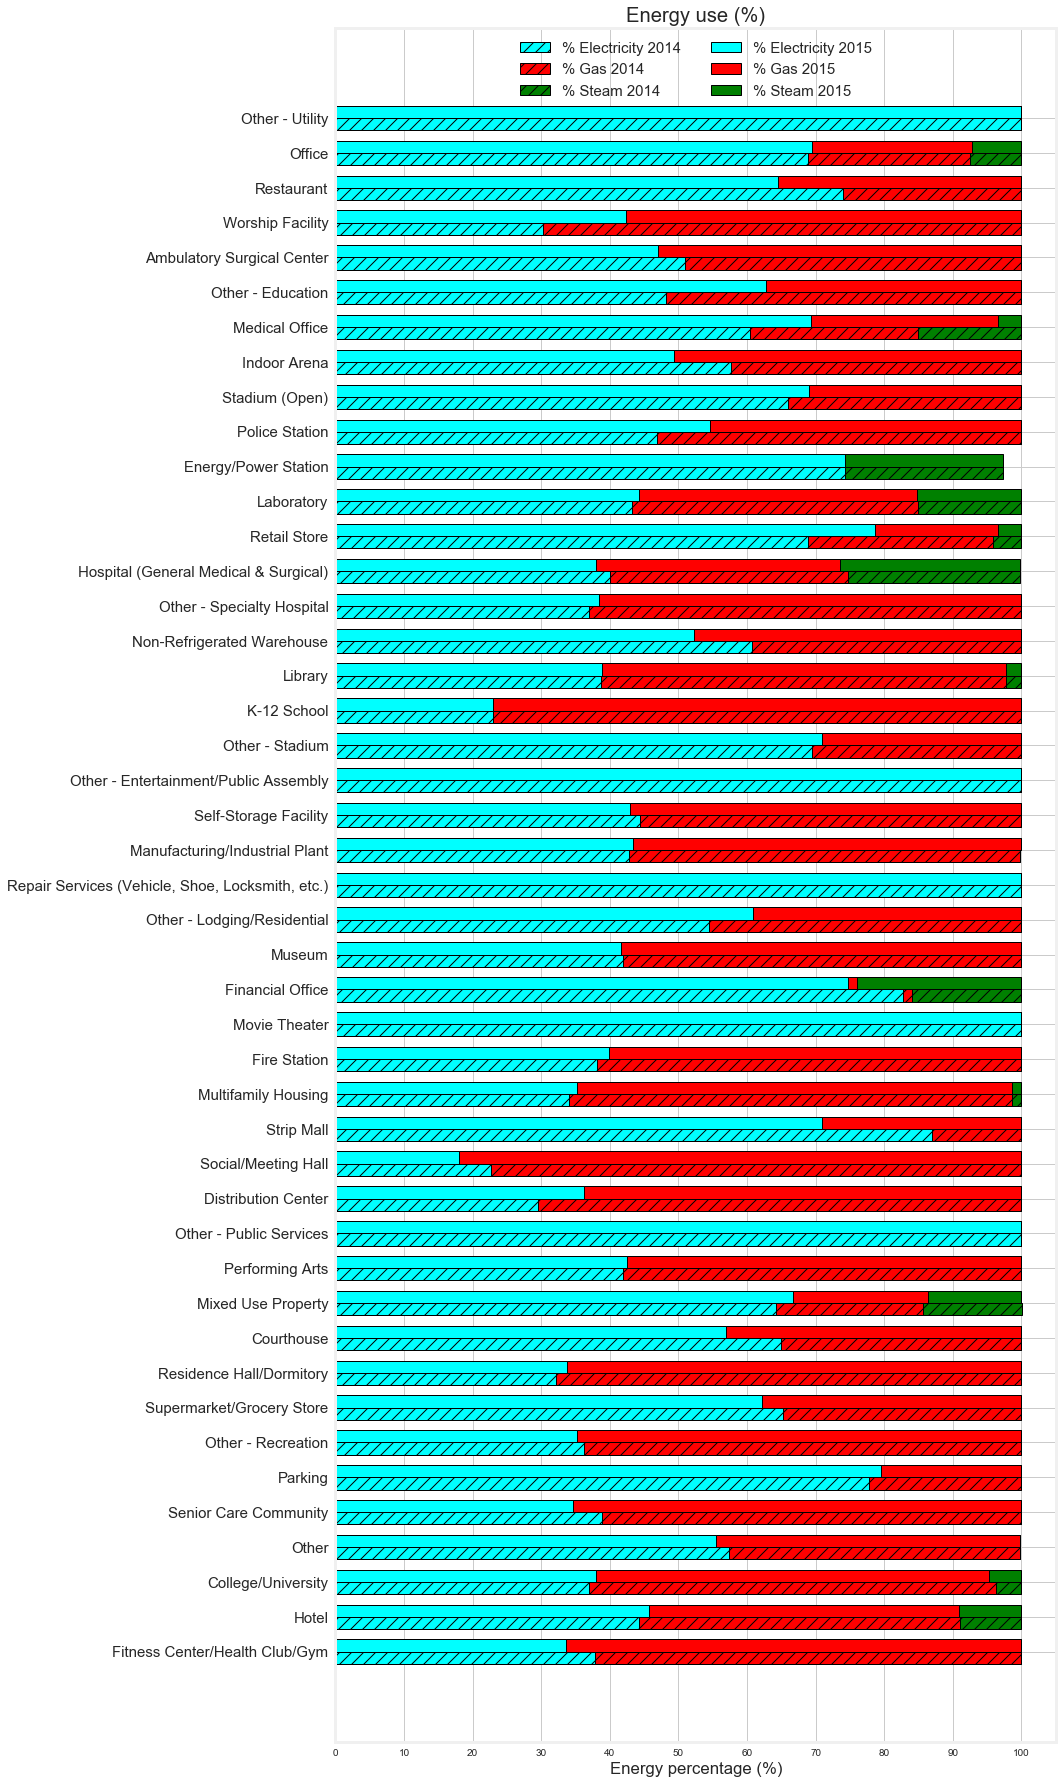

In [145]:
# data to plot
a = berdo_diff.groupby(["property_type_2015"])[['energy_kbtu/sf_diff',"%_electricity_2014",
                                               "%_gas_2014","%_steam_2014","%_electricity_2015",
                                               "%_gas_2015","%_steam_2015"]].mean()


a = a[a <1000].sort_values(by='energy_kbtu/sf_diff')


b = berdo_diff.groupby(["property_type_2015"])[['ghg_intensity_kgco2/sf_diff']].mean()
b = b[b <500].sort_values(by='ghg_intensity_kgco2/sf_diff')

c = pd.concat([a, b], axis=1).sort_values("energy_kbtu/sf_diff")

bad_energy_share = c

#stacked bars
aa=  [x+width for x in range(len(bad_energy_share.index))]
bb = [x for x in range(len(bad_energy_share.index))]



ind = np.arange(len(bad_energy_share))    # the x locations for the groups
width = 0.35       # the width of the bars: can also be len(x) sequence


fig = plt.figure(figsize=(15,25),
                 facecolor='white')

ax=plt.subplot2grid((1,1), (0,0))

w1 = ax.barh(aa,
             bad_energy_share["%_electricity_2014"],
             width,
             align="center",
             color='aqua',
             edgecolor = "black",
             linewidth = 1)
             #bottom=[x+width for x in ind])#, yerr=menStd)
w2 = ax.barh(aa,
             bad_energy_share["%_gas_2014"], 
             width,
             align="center",
             color="red",
             edgecolor = "black",
             linewidth = 1,
             left= bad_energy_share["%_electricity_2014"])#, yerr=womenStd)
w3 = ax.barh(aa,
             bad_energy_share["%_steam_2014"],
             width,
             align="center",
             color='green',
             edgecolor = "black",
             linewidth = 1,
             left= bad_energy_share["%_electricity_2014"]+bad_energy_share["%_gas_2014"])


v1= ax.barh(bb,
        bad_energy_share["%_electricity_2015"],
        width,
        align="center",
        color='aqua',
        edgecolor = "black",
        hatch="//",
        linewidth = 1)
             #bottom=[x+width for x in ind])#, yerr=menStd)
v2 = ax.barh(bb,
        bad_energy_share["%_gas_2015"], 
        width,
        align="center",
        color="red",
        edgecolor = "black",
        linewidth = 1,
        hatch="//",
        left= bad_energy_share["%_electricity_2015"])#, yerr=womenStd)
v3 = ax.barh(bb,
        bad_energy_share["%_steam_2015"],
        width,
        align="center",
        color='green',
        edgecolor = "black",
        linewidth = 1,
        hatch="//",
        left= bad_energy_share["%_electricity_2015"]+bad_energy_share["%_gas_2015"],)

ax.set_yticks([x+width/2 for x in ind])
ax.set_yticklabels([x for x in c.index], size=15)


plt.xlabel('Energy percentage (%)')
plt.title('Energy use (%)')
#plt.yticks(ind, bad_energy_share.index.values)
plt.xticks(np.arange(0,101,10))
plt.legend((v1[0], v2[0],v3[0],w1[0], w2[0],w3[0]), ('% Electricity 2014',
                                                     '% Gas 2014',
                                                     '% Steam 2014',
                                                     '% Electricity 2015',
                                                     '% Gas 2015',
                                                     '% Steam 2015'),
            prop={'size':15},
            loc='upper center',
            ncol=2)



plt.tight_layout()
plt.show()